In [440]:
import pandas as pd
import sqlite3

from scipy.stats import linregress
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from pykalman import KalmanFilter
import numpy as np

In [ ]:
#NOTE: bunch of memory duplication, but this is a notebook. don't convert to .py yet

In [167]:
bc_stations = pd.read_csv('bc_stations.txt', sep=' \t', engine='python')
# we'll need some kind of entity resolution to cut down to reservoirs -> choose resolve stations to reservoirs (leg work)

In [483]:
bc_stations

,Station Name,Years,Province,Station Number,Data Availability,Latitude,Longitude,Gross Drainage Area (km2)
0,ABERDEEN LAKE AT THE OUTLET,1968-1986,BC,08LC043,Level,"50°06'17"" N","119°04'23"" W",None
1,ADAMS LAKE NEAR SQUILAX,1949-2017,BC,08LD003,Level,"50°57'12"" N","119°40'31"" W",None
2,ADAMS RIVER NEAR SQUILAX,1911-2017,BC,08LD001,Flow and Level,"50°56'15"" N","119°39'22"" W","3,210"
3,ADSETT CREEK AT KILOMETRE 386.0 ALASKA HIGHWAY,1983-2014,BC,10CD005,Flow and Level,"58°06'21"" N","122°42'56"" W",109
4,AKIE RIVER NEAR THE 760 M CONTOUR,1981-2016,BC,07EA007,Flow and Level,"57°11'28"" N","124°54'04"" W","1,690"
5,ALCES RIVER AT 22ND BASE LINE,1963-2014,BC,07FD004,Flow and Level,"56°20'03"" N","120°09'18"" W",295
6,ALLISON LAKE NEAR PRINCETON,1973-1981,BC,08NL058,Level,"49°40'54"" N","120°36'15"" W",None
7,ALOUETTE LAKE FOREBAY,1983-1996,BC,08MH148,Level,"49°17'14"" N","122°29'04"" W",None
8,ALOUETTE RIVER NEAR HANEY,1911-2016,BC,08MH005,Flow and Level,"49°14'20"" N","122°34'47"" W",233
9,ANDERSON CREEK NEAR NELSON,1945-2017,BC,08NJ130,Flow and Level,"49°30'07"" N","117°15'40"" W",9.07


In [484]:
def filter_by_stations(df, stations):
    """
        Return only data with a station in stations
    """
    return df[df['STATION_NUMBER'].isin(stations)][:]

In [450]:
def plot_annual_averages(df, station_no):
    """
        lazy visual for annual - double check if we have weird outliers
    """
    station = df[df['STATION_NUMBER'] == station_no]
    fitline = linregress(station['YEAR'], station['MEAN'])
    # linregress val is pretty meaningless, but mostly there for context
    plt.plot(station['YEAR'], station['MEAN'])
    plt.plot(station['YEAR'], fitline.intercept + station['YEAR']*fitline.slope )
    plt.show()
    return annual_linregressor

In [463]:
def plot_daily_values(df, kalman_smoothed):
    """
        visualize basic model regresssions
    """
    loess_smoothed = lowess(df['value'], df['date'], frac=0.03, is_sorted=False)
    # again, this is mostly visual
    plt.figure(figsize=(50, 20))
    plt.plot(df['date'], df['value'], 'b.', alpha=0.5)
    plt.plot(df['date'], loess_smoothed[:, 1], 'r-')
    plt.plot(df['date'], kalman_smoothed[:, 0], 'g-')
    plt.show()

In [451]:
def get_stations_daily_data(conn, stations):
    #only works for single station now, later groupby
    stations_str = str(stations)[1:-1]
    LEVELS = ['LEVEL{}'.format(dayno) for dayno in range(1,32)]
    query = "SELECT {levels} FROM DLY_LEVELS WHERE STATION_NUMBER IN ({stations})".format(levels=LEVELS, stations=stations_str)
    print(query)
    unparsed_data = pd.read_sql_query(daily_levels_query, conn)
    return unparsed_data

In [452]:
# see http://collaboration.cmc.ec.gc.ca/cmc/hydrometrics/www/HYDAT_Definition_EN.pdf for HYDAT schema
db_filename = 'Hydat.sqlite3'
conn = sqlite3.connect(db_filename)

In [453]:
annual_query = "SELECT * FROM `ANNUAL_STATISTICS` WHERE `DATA_TYPE` = 'H';"
good_annual_stations_query = """SELECT STATION_NUMBER
                                FROM ANNUAL_STATISTICS 
                                WHERE DATA_TYPE = 'H'
                                    AND MEAN IS NOT NULL
                                GROUP BY STATION_NUMBER
                                HAVING COUNT(*) > 10;"""
bc_stations_str = str(list(bc_stations['Station Number']))[1:-1]
daily_levels_query = "SELECT * FROM DLY_LEVELS WHERE STATION_NUMBER IN ({stations})".format(stations=bc_stations_str)

In [454]:
annual_data = pd.read_sql_query(annual_query,conn) #anual statistics levels table
good_stations = pd.read_sql_query(good_annual_stations_query, conn) # stations with 'enough' data (>10 avg years)
daily_data = pd.read_sql_query(daily_levels_query, conn)#.set_index(['STATION_NUMBER','YEAR', 'MONTH']) # stations with 'enough' data (>10 avg years)

In [455]:
cleaned_annual_data = filter_by_stations(annual_data, good_stations['STATION_NUMBER']).dropna(subset=['MEAN'])
# stations w/enough years, remove years w/bananas

In [456]:
# for station_no in good_stations['STATION_NUMBER']:
#     plot_annual_averages(cleaned_data, station_no)

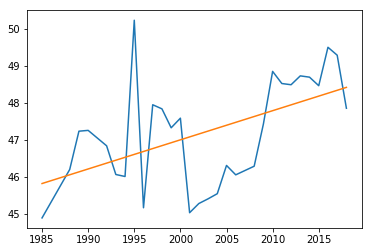

LinregressResult(slope=0.02946461504588706, intercept=692.6566558441274, rvalue=0.2824847194016734, pvalue=0.09026359285176999, stderr=0.016912720269887233)

In [485]:
my_station = '08MH149' # COQUITLAM LAKE FOREBAY
plot_annual_averages(cleaned_data, my_station)

In [486]:
daily_data
# look at max/min later on for outlier-checking or to better inform
# Later, try Kalman filter w/weather... nulls in Kalman
# there is a fullmonth and no-days tag - maybe take advantage if gapped data is too hard
# ignoring symbols, check later to see if important (may account for inaccuracies)
# they gives us precision (in m, to cm or mm), ignoring for now

,STATION_NUMBER,YEAR,MONTH,PRECISION_CODE,FULL_MONTH,NO_DAYS,MONTHLY_MEAN,MONTHLY_TOTAL,FIRST_DAY_MIN,MIN,...,LEVEL27,LEVEL_SYMBOL27,LEVEL28,LEVEL_SYMBOL28,LEVEL29,LEVEL_SYMBOL29,LEVEL30,LEVEL_SYMBOL30,LEVEL31,LEVEL_SYMBOL31
0,07EA004,2011,1,8,1,31,2.211,68.549,31.0,2.097,...,2.205,None,2.191,None,2.177,None,2.146,None,2.097,None
1,07EA004,2011,2,8,1,28,2.125,59.487,1.0,2.062,...,2.125,None,2.117,None,NaN,None,NaN,None,NaN,None
2,07EA004,2011,3,8,1,31,2.053,63.634,29.0,1.943,...,1.956,None,1.946,None,1.943,None,1.944,None,1.944,None
3,07EA004,2011,4,8,1,30,1.915,57.461,22.0,1.876,...,1.924,None,1.932,None,1.946,None,1.961,None,NaN,None
4,07EA004,2011,5,8,1,31,3.001,93.037,1.0,1.971,...,4.003,None,4.245,None,4.499,None,4.525,None,4.545,None
5,07EA004,2011,6,8,1,30,4.099,122.981,14.0,3.608,...,4.196,None,4.109,None,4.048,None,3.914,None,NaN,None
6,07EA004,2011,7,8,1,31,3.564,110.493,31.0,3.280,...,3.428,None,3.374,None,3.345,None,3.296,None,3.280,None
7,07EA004,2011,8,8,1,31,3.083,95.585,14.0,2.913,...,3.055,A,3.015,A,3.022,None,3.049,None,3.040,A
8,07EA004,2011,9,8,1,30,2.965,88.949,20.0,2.785,...,3.123,None,3.094,None,3.069,None,3.058,None,NaN,None
9,07EA004,2011,10,8,1,31,2.779,86.152,31.0,2.603,...,2.640,None,2.630,None,2.624,None,2.616,None,2.603,None


In [487]:
station_day_data = filter_by_stations(daily_data, [my_station])#daily_data.loc[[my_station]]
melted_day_data = station_day_data.melt(id_vars = ['YEAR', 'MONTH'], value_vars=LEVELS).dropna()
melted_day_data['date'] = pd.to_datetime(melted_day_data['YEAR'].map(str) + '-' + melted_day_data['MONTH'].map(str)+ '-' + melted_day_data['variable'].str[5:])
melted_day_data.set_index('date', inplace=True)
melted_day_data.sort_index(inplace=True)
melted_day_data.reset_index(inplace=True)

In [477]:
df = melted_day_data[:]
df['date'] = df['date'].astype(np.int64) // 1e9 # convert dates to time
df

,date,YEAR,MONTH,variable,value
0,462585600,1984,8,LEVEL29,45.397999
1,462672000,1984,8,LEVEL30,45.313999
2,462758400,1984,8,LEVEL31,45.247002
3,462844800,1984,9,LEVEL1,45.174000
4,462931200,1984,9,LEVEL2,45.105000
5,463017600,1984,9,LEVEL3,44.998001
6,463104000,1984,9,LEVEL4,44.948002
7,463190400,1984,9,LEVEL5,44.997002
8,463276800,1984,9,LEVEL6,45.236000
9,463363200,1984,9,LEVEL7,45.339001


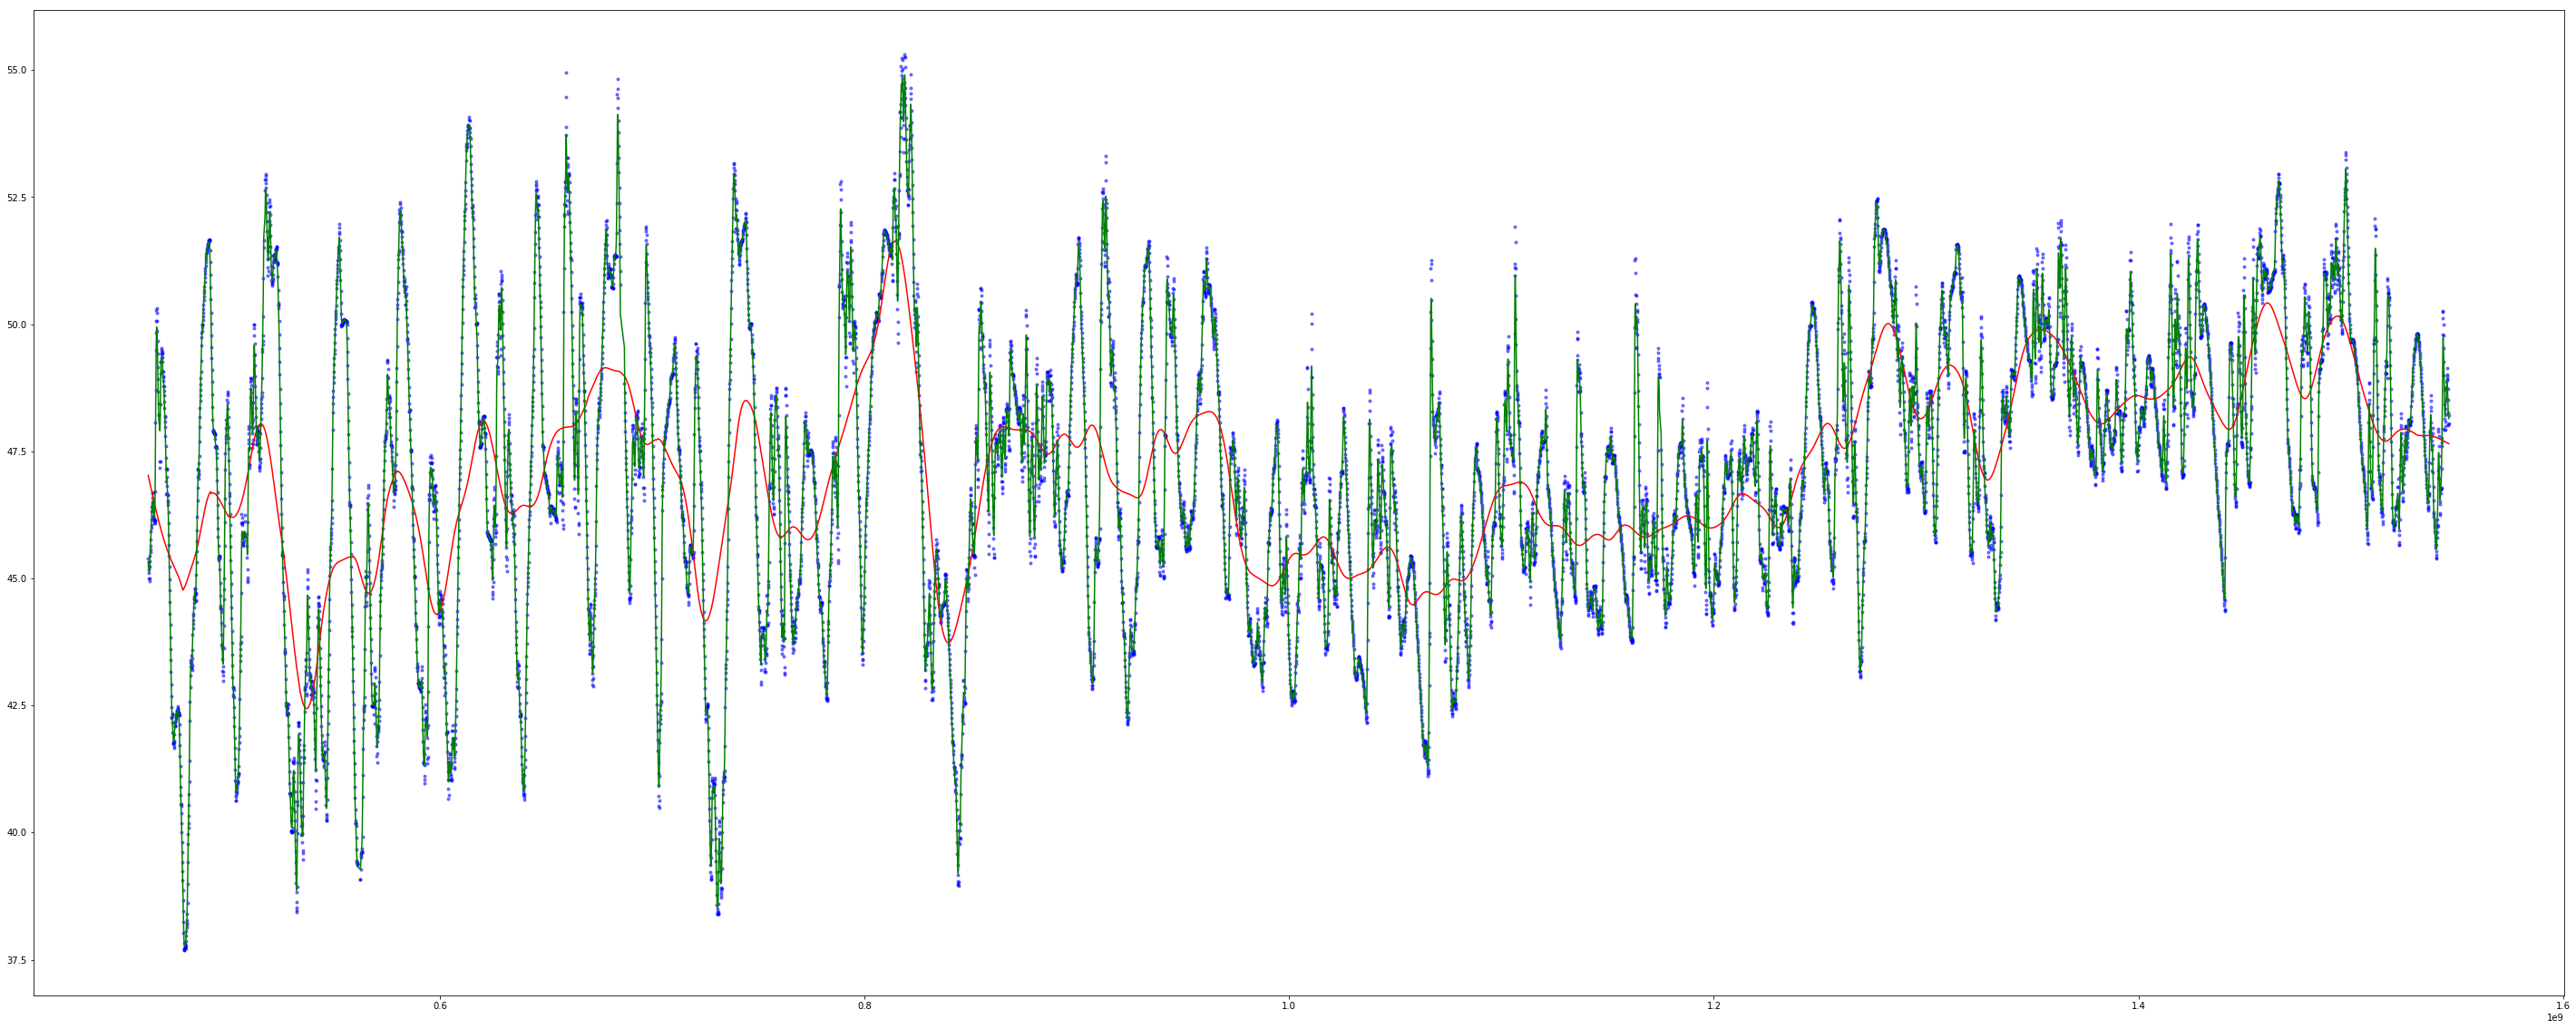

In [482]:
kalman_data = df[['value', 'date']]
initial_state = kalman_data.iloc[0]
observation_covariance = np.diag([1, 0.01]) ** 2
transition_covariance = np.diag([0.5, 0.02]) ** 2
transition = [[1, 0], [0, 1]]
# work out the proper values later. add weather to this later on - will inform precip

kf = KalmanFilter(initial_state_mean=initial_state,
                  observation_covariance=observation_covariance,
                  transition_covariance=transition_covariance,
                  transition_matrices=transition)
kalman_smoothed, _ = kf.smooth(kalman_data)

plot_daily_values(df, kalman_smoothed)
